<br>
<center><font size = 10> B-Spline using Bayes' theorem </font> </center>
<br><br>
<img src= "./ml_img/gaussian_bayes.PNG">

<br>

<div style = "text-align : right">
    <font size = 6> 19/03/26 이성령</font>
</div>

<center>
<font size = 6>    
Prior  
</font>
</center> <br>
<center><font size = 4>
$p(w|\alpha) = N(w|0 , \alpha^{-1}I)$ <br> 
</font></center>

--- 
<center>
<font size = 6>  
 Likelihood 
</font>
</center> <br>

<center><font size = 4> 
$p(t|X,w,\beta) = \prod_{i=1}^N N(t_i | w^{T}\phi(x_i), \beta^{-1})$ <br>
$p(t|w,\beta) = p(t|x,w,\beta)$
</font></center>

--- 

<center>
<font size = 6>  
Posterior 
</font>
</center> <br>

<center><font size = 4>
    $p(w|t,\alpha , \beta) = \frac{p(t|w,\beta)p(w|\alpha)}{p(t|\alpha,\beta)}$
    $ = \frac{p(t|x,w,\beta)p(w|\alpha)}{p(t|\alpha,\beta)}$  <br>
    $p(w|t,\alpha , \beta) = N(w | m_N , S_N)$ <br> 
</font></center> <br>
<center>
<font size = 3>$m_{N} = \beta S_N \phi^{T}t$ <br>  $S_N^{-1} = \alpha I + \beta \phi^{T}\phi$ <br></font></center>



--- 

<center>
<font size = 6>  
 Posterior Predictive 
    </font>

</center> <br>

<center><font size = 4>
$p(t|w,\beta) = p(t|x,w,\beta)$ <br>
$p(t^{*}|x,t,\alpha,\beta) = \int p(t^{*}|x,w,\beta)p(w|t,\alpha,\beta)dw $ <br>
$ \quad \quad = N(t|m_N^{T}\phi(x) , \sigma^2_{N}(x))$ <br>
$\sigma^2_{N}(x) = \frac{1}{\beta} + \phi(x)^T S_N\phi(x)$
</font> <br> </center>

<center>
$p(t^{*}|X,w,\beta) = N(t^{*} | w^{T}\phi(x), \beta^{-1}) $
<br>
$p(w|t,\alpha , \beta) = N(w | m_N , S_N)$
</center>

---


In [93]:
import numpy as np
from scipy import stats

def posterior(Phi, t, alpha, beta, return_inverse=False):
    """ 위에 있는 공식을 구현하면 다음과 같이 나옴. """
    """ alpha 는 사전 분포의 Precision = 분산의 역수"""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    """y 는 posterior predict의 평균"""
    """y_var 는 posterior predict의 분산"""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum( Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

def gaussian_basis_function(x, mu, sigma=1/8):
    """ Basis Gaussian Function """
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

def expand(x, bf, bf_args=None) :
    """ theta_0 는 1의 weight를 가지므로 np.ones"""
    """ theta : theta_1 ~ theta_9"""
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

In [94]:
def g(X, noise_variance):
    '''Sinus function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)

def noise(size, variance):
    """ Beta : Precision """
    return np.random.normal(loc= 0 , scale=np.sqrt(variance), size = size)

In [95]:
def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


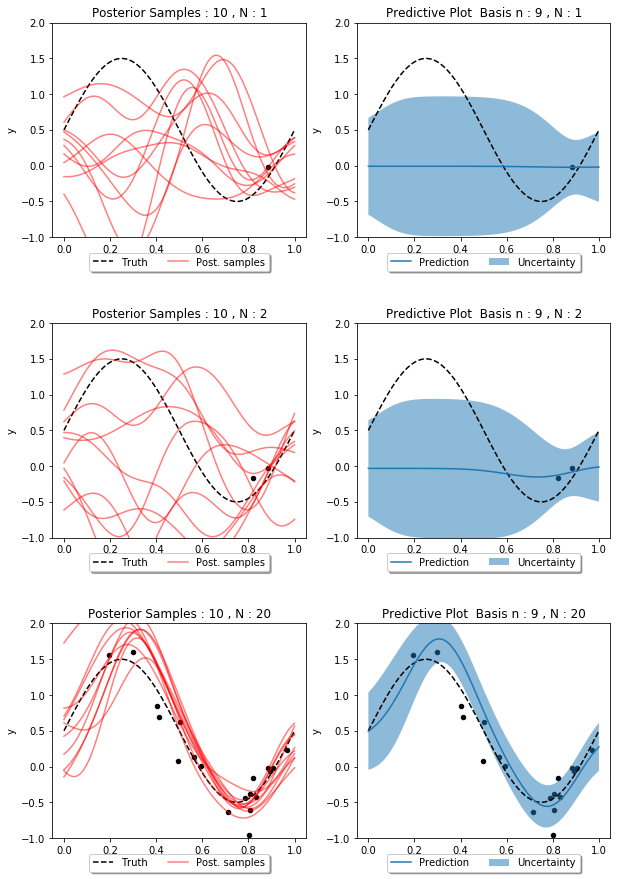

In [137]:
import matplotlib.pyplot as plt

N_list = [1 , 2 , 20 ]

test_min , test_max , test_n = 0  , 1 , 100
kernel_mean_min , kernel_mean_max = 1/9 , 1
basis_f_n = 9
sample_n = 10
beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
""" 0 ~ 1 사이에 임의로 샘플 x 생성"""
X = np.random.uniform(size=[N_list[-1],1] , high= test_max , low=test_min)

# Training target values
""" X 샘플에서 DGP y 값 뽑기 """
t = g(X, noise_variance= 1 / beta )

# Test observations
""" 해당 영역에서 x 샘플 고르게 생성"""
X_test = np.linspace(test_min , test_max , test_n).reshape(-1, 1)

# Function values without noise 
""" 고르게 생성한 샘플에서 DGP True Model"""
y_true = g(X_test, noise_variance=0)
    
# Design matrix of test observations
""" 고르게 생성한 샘플에서 가우시안 기저모형 만들기"""
Phi_test = expand(X_test, bf=gaussian_basis_function,
                  bf_args=np.linspace(kernel_mean_min ,
                                      kernel_mean_max , basis_f_n))

plt.figure(figsize=(10, 15))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    """임의의 샘플에서 뽑은 개수 만큼을 이용한 가우시안 기저 모형 """
    Phi_N = expand(X_N, bf=gaussian_basis_function,
                   bf_args=np.linspace(test_min , test_max  , basis_f_n ))

    # Mean and covariance matrix of posterior
    """ 만들어진 기저 모형를 이용해 사후 분포 평균 , 분산 구하기"""
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    """ 생성된 기저 모형에 사후 평균 , 분산으로 Update 후 출력"""
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    """ 사후 분포의 샘플을 몇개 뽑아서 , 라인이 어떻게 그려는지 확인"""
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, sample_n  ).T
    y_samples = Phi_test.dot(w_samples)
    plt.subplot(len(N_list), 2, i * 2 + 1)
    """ Sample Scatter """
    plot_data(X_N, t_N) 
    """True Line"""
    plot_truth(X_test, y_true) 
    """ 사후 분포 샘플에 따른 Line """
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.0, 2.0)
    plt.title("Posterior Samples : {} , N : {}".format(sample_n, N))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
    
    plt.subplot(len(N_list), 2, i * 2 + 2)
    """ Sample Scatter """
    plot_data(X_N, t_N)
    """True Line"""
    plot_truth(X_test, y_true, label=None)
    """ Test 값에 대한 예측 평균값과 신뢰구간"""
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.0, 2.0)
    plt.title("Predictive Plot  Basis n : {} , N : {}".format(basis_f_n , N))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)


<center><font size = 10> Maximization $\alpha , \beta$</font></center><br>


<center><font size = 4> 
$\alpha = \frac{\gamma}{m_N^Tm_N}$ <br><br>
$\frac{1}{\beta} = \frac{1}{N-\gamma}\sum_{i=1}^N(t_i -m_N^T\phi(x_i))^2$ <br><br>
$\gamma = \sum_{i=0}^{M-1}\frac{\lambda_i}{\alpha + \lambda_i}$<br>  
</font></center>
$\lambda_i = \beta\phi^T\phi$의 eigenvalues

In [128]:
def fit(Phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    """ Jointly infers the posterior sufficient statistics and optimal values for alpha and beta by maximizing the log marginal likelihood. Args: Phi: Design matrix (N x M). t: Target value array (N x 1). alpha_0: Initial value for alpha. beta_0: Initial value for beta. max_iter: Maximum number of iterations. rtol: Convergence criterion. Returns: alpha, beta, posterior mean, posterior covariance. """
    
    N, M = Phi.shape

    eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))

    beta = beta_0
    alpha = alpha_0

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha

        eigenvalues = eigenvalues_0 * beta

        m_N, S_N, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m_N ** 2)

        beta_inv = 1 / (N - gamma) * np.sum((t - Phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv

        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print('Convergence after {} iterations.'.format(i + 1))
            return alpha, beta, m_N, S_N

    if verbose:
        print('Stopped after {} iterations.'.format(max_iter))
    return alpha, beta, m_N, S_N

In [145]:
N = 100

X = np.linspace(0, 1, N).reshape(-1, 1)
t = g(X, noise_variance=0.3 ** 2)
kernel_mean_min , kernel_mean_max , basis_f_n = 1/9 , 1 , 9

Phi = expand(X, bf=gaussian_basis_function,
             bf_args=np.linspace(kernel_mean_min ,
                                 kernel_mean_max , basis_f_n))
alpha, beta, m_N, S_N = fit(Phi, t, rtol=1e-5, verbose=True)

Convergence after 6 iterations.


In [150]:
print( "Alpha : {} , Beta : {}".format(alpha, beta))

Alpha : 4.309711205038496 , Beta : 12.046637624466378


In [148]:
m_N.ravel()

array([ 0.32943351,  0.19123722,  0.60200948,  0.46557857,  0.33308647,
       -0.1299704 , -0.32127389, -0.43877665, -0.40917314,  0.44445725])

In [136]:
S_N.ravel()

array([ 0.07697928, -0.06987919, -0.00830705, -0.02509097, -0.03236105,
       -0.02568612, -0.0276281 , -0.02330811, -0.02855132, -0.04220686,
       -0.06987919,  0.10951919, -0.04852472,  0.04964318,  0.02914264,
        0.01648387,  0.02817962,  0.02173393,  0.02468559,  0.03883409,
       -0.00830705, -0.04852472,  0.10884013, -0.079658  ,  0.0284649 ,
        0.01025592, -0.00676306,  0.00461759,  0.00520397,  0.00278566,
       -0.02509097,  0.04964318, -0.079658  ,  0.12534606, -0.06972912,
        0.02992668,  0.01740818, -0.00138644,  0.01057134,  0.01559875,
       -0.03236105,  0.02914264,  0.0284649 , -0.06972912,  0.12998766,
       -0.06969933,  0.03363073,  0.01801123,  0.00247328,  0.02058074,
       -0.02568612,  0.01648387,  0.01025592,  0.02992668, -0.06969933,
        0.12621628, -0.07199969,  0.02918529,  0.01980274,  0.00326638,
       -0.0276281 ,  0.02817962, -0.00676306,  0.01740818,  0.03363073,
       -0.07199969,  0.127617  , -0.07160743,  0.03025959,  0.02


# <참고>

[구현 예제 1](http://krasserm.github.io/2019/02/23/bayesian-linear-regression/) <br>
[필요 함수](https://github.com/krasserm/bayesian-machine-learning/blob/master/bayesian_linear_regression_util.py)